<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/DaapLearning02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # === [1] Import Libraries ===
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
# === [2] Mount Google Drive ===
# Mount Google Drive agar bisa akses dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Dataset_DeepLearning'
import os
print(os.listdir(data_dir))

Mounted at /content/drive
['test', 'training', 'val', 'predict']


In [ ]:
# === [3] Data Transforms ===
# Transformasi data dan augmentasi
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop acak dengan skala
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Variasi warna
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translasi posisi
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# === [4] Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'training'), transform=transform_train)
val_data = ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data = ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes

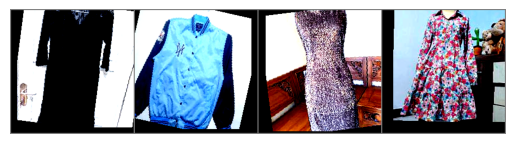

gaun jaket gaun gaun


In [ ]:
# === [5] Visualize Sample Images ===
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(4)))

In [ ]:
# === [6] Load Pretrained Model (ResNet18 + Dropout) ===
import torch.nn as nn
from torchvision import models

# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model pretrained
model = models.resnet18(pretrained=True)

# Ambil jumlah fitur input dari FC terakhir
num_ftrs = model.fc.in_features

# Tambahkan Dropout dan ganti FC untuk jumlah kelas kamu
model.fc = nn.Sequential(
    nn.Dropout(0.5),                     # Dropout 50% (untuk regularisasi)
    nn.Linear(num_ftrs, len(class_names))  # Output sesuai jumlah kelas
)

# Pindahkan model ke device (GPU/CPU)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [ ]:
# === [7] Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [9]:
# === [8] Training Loop ===
early_stopping = EarlyStopping(patience=8, verbose=True, path='best_model.pt')

epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    # Early Stopping Check
    early_stopping(val_losses[-1], model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch [1/50], Train Loss: 1.0524, Val Loss: 1.5724, Val Acc: 51.67%
Validation loss decreased (inf → 1.572382). Saving model...
Epoch [2/50], Train Loss: 0.6439, Val Loss: 1.2534, Val Acc: 67.78%
Validation loss decreased (1.572382 → 1.253422). Saving model...
Epoch [3/50], Train Loss: 0.4453, Val Loss: 1.0041, Val Acc: 66.11%
Validation loss decreased (1.253422 → 1.004129). Saving model...
Epoch [4/50], Train Loss: 0.3507, Val Loss: 0.6956, Val Acc: 78.89%
Validation loss decreased (1.004129 → 0.695602). Saving model...
Epoch [5/50], Train Loss: 0.4419, Val Loss: 1.0060, Val Acc: 75.56%
EarlyStopping counter: 1 out of 8
Epoch [6/50], Train Loss: 0.3062, Val Loss: 1.5787, Val Acc: 70.56%
EarlyStopping counter: 2 out of 8
Epoch [7/50], Train Loss: 0.2402, Val Loss: 1.1850, Val Acc: 72.78%
EarlyStopping counter: 3 out of 8
Epoch [8/50], Train Loss: 0.2627, Val Loss: 2.1893, Val Acc: 62.78%
EarlyStopping counter: 4 out of 8
Epoch [9/50], Train Loss: 0.2570, Val Loss: 0.5150, Val Acc: 83.8

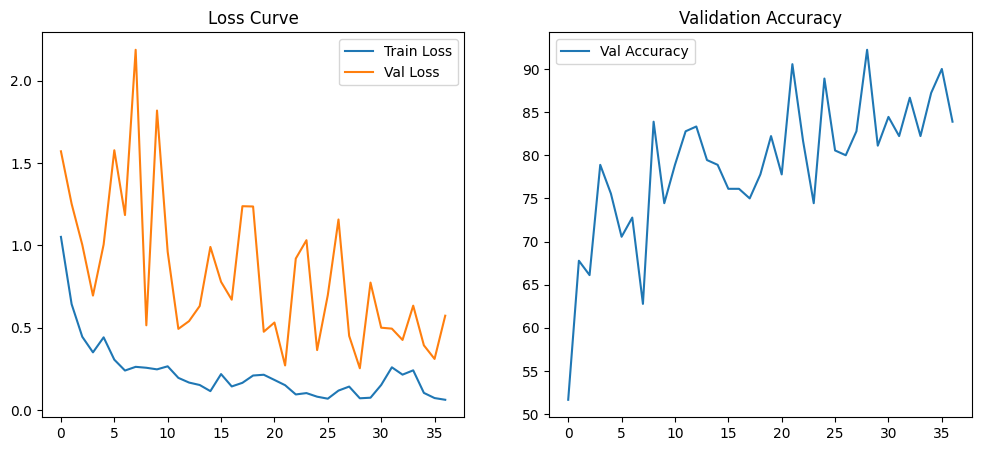

In [10]:
# === [9] Plotting Loss and Accuracy ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


Classification Report:
              precision    recall  f1-score   support

        gaun       0.73      0.67      0.70        45
       jaket       0.87      0.89      0.88        45
        kaos       0.60      0.93      0.73        45
      kemeja       0.87      0.44      0.59        45

    accuracy                           0.73       180
   macro avg       0.77      0.73      0.72       180
weighted avg       0.77      0.73      0.72       180



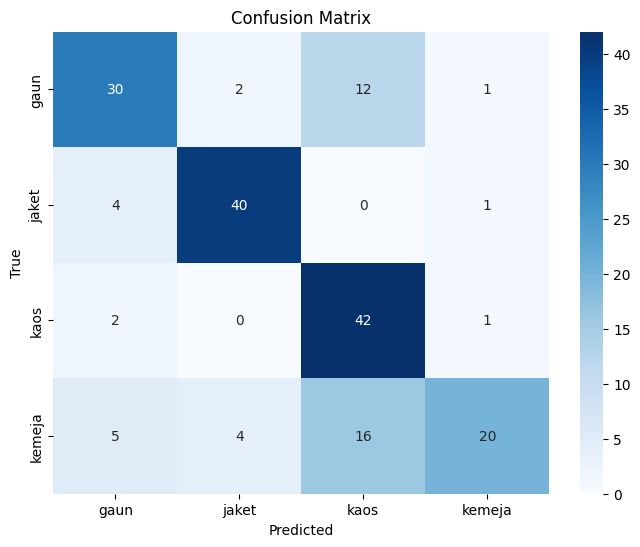

In [11]:
# === [10] Evaluate on Test Set ===
model.eval()
preds, truths = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        truths.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(truths, preds, target_names=class_names))

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# === [11] Error Rate Analysis ===
errors = [(p, t) for p, t in zip(preds, truths) if p != t]
print(f"Total Misclassified Samples: {len(errors)}")

In [ ]:
# === [12] Grad-CAM Visualization ===
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- Inisialisasi penyimpan ---
activations = {}
gradients = {}

# Fungsi hook
def forward_hook(module, input, output):
    activations['value'] = output

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0]

# Pasang hook di layer terakhir convolution
target_layer = model.layer4[-1]

# Pasang hook
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)  # Ganti yang ini

# Fungsi gradcam
def generate_gradcam(image_tensor, class_idx=None):
    model.eval()
    activations.clear()
    gradients.clear()

    image_tensor = image_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output)

    output[:, class_idx].backward()

    grad = gradients['value'].squeeze(0)        # [C, H, W]
    act = activations['value'].squeeze(0)       # [C, H, W]

    pooled_grad = grad.mean(dim=[1, 2])   # [C]
    print("Shape of grad:", grad.shape)
    print("Shape of act:", act.shape)
    print("Shape of pooled_grad:", pooled_grad.shape)

    for i in range(act.shape[0]):
        act[i] *= pooled_grad[i].item()  # <- Gunakan .item()

    heatmap = act.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap

# ==== Menampilkan hasilnya ====

# Ambil contoh gambar dari test set
sample_img, _ = test_data[0]

# Generate heatmap
heatmap = generate_gradcam(sample_img)

# Konversi gambar asli ke format numpy
img = sample_img.permute(1, 2, 0).cpu().numpy()
img -= img.min()
img /= img.max()

# Tampilkan gambar asli + heatmap
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Result")
plt.axis('off')
plt.show()

In [14]:
# === [13] Predict New Image ===
import os
from PIL import Image

def predict_from_folder(folder_path, model, transform, class_names):
    model.eval()
    predictions = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                predicted_class = class_names[pred.item()]
                predictions.append((filename, predicted_class))

    return predictions

# === Jalankan Prediksi ===
predict_path = "/content/drive/MyDrive/Dataset_DeepLearning/predict"
results = predict_from_folder(predict_path, model, transform_test, class_names)

# === Tampilkan hasilnya ===
for fname, pred in results:
    print(f"{fname} => Predicted: {pred}")



img2.jpg => Predicted: gaun
img1.jpg => Predicted: jaket
img3.jpg => Predicted: kaos
img5.jpg => Predicted: kemeja
img4.jpg => Predicted: kemeja


In [15]:
# === [12] Predict New Image ===
import os
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    model.eval()

    # ✅ Tambahan pengecekan file
    if not os.path.exists(image_path):
        print(f"❌ File '{image_path}' tidak ditemukan. Cek kembali nama dan lokasinya ya.")
        return

    # ✅ Lanjut prediksi kalau file aman
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output, 1)

    predicted_class = class_names[pred.item()]
    print(f"✅ Predicted Class: {predicted_class}")

# ✅ Contoh pemanggilan
predict_image("/content/drive/MyDrive/Dataset_DeepLearning/predict/img1.jpg", model, transform_test, class_names)


✅ Predicted Class: jaket
